# HSE 2021: Mathematical Methods for Data Analysis

## Homework 3

**Warning 1**: some problems require (especially the lemmatization part) significant amount of time, so **it is better to start early (!)**

**Warning 2**: it is critical to describe and explain what you are doing and why, use markdown cells

In [2]:
from typing import Tuple, List

import matplotlib.pyplot as plt
import morph as morph
import nltk
import numpy as np
import pandas as pd
import pymorphy2.analyzer
import seaborn as sns
import txt as txt
%matplotlib inline

sns.set(style="darkgrid")

## PART 1: Logit model

We consider a binary classification problem. For prediction, we would like to use a logistic regression model. For regularization we add a combination of the $l_2$ and $l_1$ penalties (Elastic Net). 

Each object in the training dataset is indexed with $i$ and described by pair: features $x_i\in\mathbb{R}^{K}$ and binary labels $y_i$. The model parametrized with bias $w_0\in\mathbb{R}$ and weights $w\in\mathbb{R}^K$.

The optimization problem with respect to the $w_0, w$ is the following (Elastic Net Loss):

$$L(w, w_0) = \frac{1}{N} \sum_{i=1}^N \ln(1+\exp(-y_i(w^\top x_i+w_0))) + \gamma \|w\|_1 + \beta \|w\|_2^2$$.

#### 1. [0.5 points]  Find the gradient of the Elastic Net loss and write its formulas (better in latex format) 

##### Put your markdown formulas here
$$\frac{dL(w, w_0)}{dw_0} = \frac{1}{N}\sum_{i=1}^{N}\frac{exp(-y_{i}(w^{T}X_{i}^T + w_{0}))}{1 + exp(-y_{i}(w^{T}X_{i}^T + w_{0}))}(-y_i)$$

$$\frac{dL(w, w_0)}{dw_j} = \frac{1}{N}\sum_{i=1}^{N}\frac{exp(-y_{i}(w^{T}X_{i}^T + w_{0}))}{1 + exp(-y_{i}(w^{T}X_{i}^T + w_{0}))}(-y_i)*(x_{ij}) + \gamma * sgn(w_j) + 2 * \beta * w_j$$
$$\frac{dL(w, w_0)}{dw} = (\frac{dL(w, w_0)}{dw_1}, \frac{dL(w, w_0)}{dw_2}, ... , \frac{dL(w, w_0)}{dw_n})$$, где $X_i$ - i-ая строка матрицы X, j - от 1 до len(w)


#### 2. [0.25 points] Implement the Elastic Net loss (as a function)

In [3]:
def loss(X, y, w: List[float], w0: float, gamma=1., beta=1.) -> float:
    return 1 / X.shape[0] * np.sum(np.log(1 + np.exp(-y * (np.sum(X * w, axis=1) + w0)))) + \
           gamma * np.sum(np.abs(w)) + beta * np.sum(np.square(w))

#### 3. [0.25 points] Implement the gradient (as a function)


#### Check yourself

In [4]:
def get_grad(X, y, w: List[float], w0: float, gamma=1., beta=1.) -> Tuple[List[float], float]:

    grad_w0 = 1 / X.shape[0] * \
             np.sum(1 / (1 + np.exp(-y * (np.sum(X * w, axis=1) + w0))) *
                    (np.exp(-y * (np.sum(X * w, axis=1) + w0)) * (-y)))
    grad_w = 1 / X.shape[0] * \
             np.sum(X.T * (1 / (1 + np.exp(-y * (np.sum(X * w, axis=1) + w0))) *
                    (np.exp(-y * (np.sum(X * w, axis=1) + w0)) * (-y))), axis=1) + \
              + gamma * np.sign(w) + 2 * beta * w
    return grad_w, grad_w0

np.random.seed(42)
X = np.random.multivariate_normal(np.arange(5), np.eye(5), size=10)
y = np.random.binomial(1, 0.42, size=10)
w, w0 = np.random.normal(size=5), np.random.normal()
grad_w, grad_w0 = get_grad(X, y, w, w0)
print(grad_w)
print(grad_w0)
assert(np.allclose(grad_w,
                   [-2.73262076, -1.87176281, 1.30051144, 2.53598941, -2.71198109],
                   rtol=1e-2) &
      np.allclose(grad_w0,
                -0.2078231418067844,
                rtol=1e-2)
)

[-2.73262181 -1.87176392  1.30051023  2.53598816 -2.71198278]
-0.20782319347690745


####  4. [1 point]  Implement gradient descent which works for both tol level and max_iter stop criteria and plot the decision boundary of the result

The template provides basic sklearn API class. You are free to modify it in any convenient way.

In [5]:
from sklearn.base import BaseEstimator, ClassifierMixin

F1-measure:   0.98
Accuracy:   0.98
ROC-AUC  =    1.00


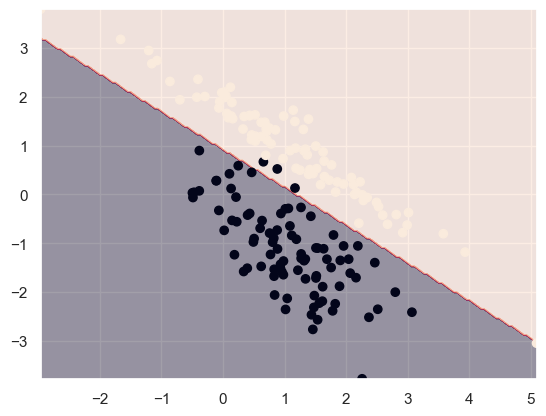

In [6]:
class Logit(BaseEstimator, ClassifierMixin):
    def __init__(self, beta=1.0, gamma=1.0, lr=1e-3, tolerance=0.01, max_iter=1000, random_state=42):
        self.beta = beta        
        self.gamma = gamma
        self.tolerance= tolerance
        self.max_iter= max_iter
        self.lr = lr
        self.random_state = random_state
        self.w = None
        self.w0 = None
        self.loss_history = []


    def full_gradient_descent(self, X, y):
        iterations = 0
        w_prev = self.w.copy()
        w0_prev = self.w0
        while iterations < self.max_iter and (np.linalg.norm(self.w - w_prev) - self.tolerance >= 0
                                               or iterations == 0 or np.linalg.norm(self.w0 - w0_prev) - self.tolerance >= 0):
            iterations += 1
            w_prev = self.w.copy()
            w0_prev = self.w0
            gradient_w, gradient_w0 = get_grad(X, y, self.w, self.w0, self.gamma, self.beta)
            self.w -= self.lr * gradient_w
            self.w0 -= self.lr * gradient_w0
            self.loss_history.append(loss(X, y, self.w, self.w0, self.gamma, self.beta))

        
    def fit(self, X, y):
        self.loss_history = []
        np.random.seed(self.random_state)
        self.w, self.w0 = np.random.normal(0,1, size=X.shape[1]), np.random.normal(0, 1, size=1)
        self.full_gradient_descent(X, y)

        return self
    
    def predict(self, X):
        if self.w is None:
            raise Exception('Not trained yet')
        predict = self.predict_proba(X).T.argmax(axis=1)
        predict[predict == 0] = -1
        predict[predict == 1] = 1
        return predict
        
    def predict_proba(self, X):
        predict_proba = np.array([1 / (1 + np.exp(np.dot(X, self.w) + self.w0)),
                         1 / (1 + np.exp(-np.dot(X, self.w) - self.w0))])
        return predict_proba


from sklearn.datasets import make_classification
X, y = make_classification(n_samples=180, n_features=2, n_redundant=0, n_informative=2,
                               random_state=42, n_clusters_per_class=1)



def plot_decision_boundary(model, X, y):
    fig = plt.figure()
    X1min, X2min = X.min(axis=0)
    X1max, X2max = X.max(axis=0)
    x1, x2 = np.meshgrid(np.linspace(X1min, X1max, 200),
                         np.linspace(X2min, X2max, 200))
    ypred = model.predict(np.c_[x1.ravel(), x2.ravel()])
    ypred = ypred.reshape(x1.shape)
    
    plt.contourf(x1, x2, ypred, alpha=.4)
    plt.scatter(X[:,0], X[:,1], c=y)

from sklearn.metrics import  f1_score, accuracy_score, roc_auc_score
model = Logit(0,0, lr=1e-2, tolerance=0.00001, max_iter=20000)
y[y == 0] = -1
model.fit(X, y)
plot_decision_boundary(model, X, y)
loss_history = model.loss_history
y_pred = model.predict(X)
proba  = model.predict_proba(X).T

print("F1-measure: {0:6.2f}".format(f1_score(y, y_pred, average='weighted')))
print("Accuracy: {0:6.2f}".format(accuracy_score(y, y_pred)))
print("ROC-AUC  =  {0:6.2f}".format(roc_auc_score(y, proba[:,1]),))

#### 5. [0.25 points] Plot loss diagram for the model, i.e. show the dependence of the loss function from the gradient descent steps

Text(0, 0.5, 'Loss function values')

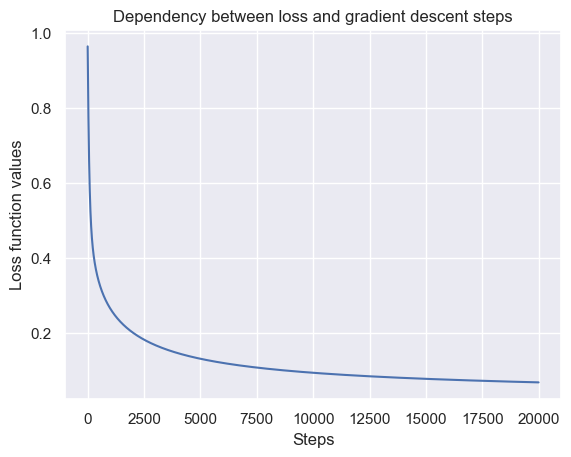

In [7]:
count = len(loss_history)
list_of_indexes = np.arange(count)
plt.plot(list_of_indexes, loss_history)
plt.title("Dependency between loss and gradient descent steps")
plt.xlabel('Steps')
plt.ylabel('Loss function values')

## PART 2: Support Vector Machines

#### 6. [2 point] Using the same dataset, train SVM Classifier from Sklearn.
Investigate how different parameters influence the quality of the solution:
+ Try several kernels: Linear, Polynomial, RBF (and others if you wish). Some Kernels have hypermeters: don't forget to try different.
+ Regularization coefficient 

Show how these parameters affect accuracy, roc_auc and f1 score. 
Make plots for the dependencies between metrics and parameters. 
Try to formulate conclusions from the observations. How sensitive are kernels to hyperparameters? How sensitive is a solution to the regularization? Which kernel is prone to overfitting?

Каждый график иллюстрирует зависимость одной из 3-х метрик от какого-то параметра модели.
При этом все параметры модели, отличные от выбранного параметра, фиксированы. Изменяется
только параметр, зависимость метрик от которого мы хотим изобразить.

In [8]:
from sklearn.metrics import mean_squared_error, r2_score, f1_score, accuracy_score, roc_auc_score
from sklearn import svm

kernels = ['linear', 'rbf', 'poly']
f1_scores = []
accuracies = []
roc_auc_scores = []
for i in kernels:
    model = svm.SVC(kernel=i, gamma='scale',tol=1e-2, probability=True)
    model.fit(X, y)
    y_pred = model.predict(X)
    proba  = model.predict_proba(X)
    f1_scores.append(f1_score(y, y_pred, average='weighted'))
    accuracies.append(accuracy_score(y, y_pred))
    roc_auc_scores.append(roc_auc_score(y, proba[:,1]))

Лучшие результаты по всем метрикам наблюдаются при использовании 'poly' ядра
(все параметры, кроме kernel, инициализированы дефолтными значениями)
Худшие результаты по всем метрикам наблюдаются у 'linear'  ядра

Text(0.5, 1.0, 'Dependency between F1-score and Kernel')

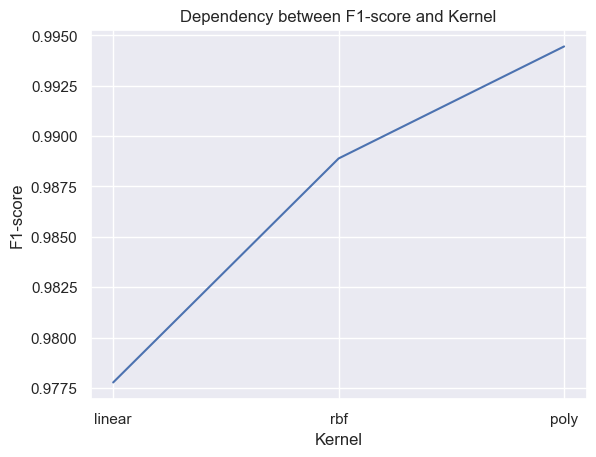

In [8]:
plt.plot(kernels, f1_scores)
plt.xlabel('Kernel')
plt.ylabel('F1-score')
plt.title('Dependency between F1-score and Kernel')

Text(0.5, 1.0, 'Dependency between Accuracy and Kernel')

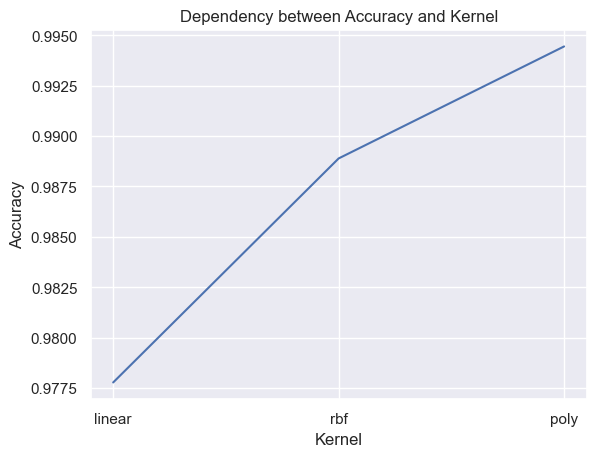

In [9]:
plt.plot(kernels, accuracies)
plt.xlabel('Kernel')
plt.ylabel('Accuracy')
plt.title('Dependency between Accuracy and Kernel')

Text(0.5, 1.0, 'Dependency between Roc-Auc score and Kernel')

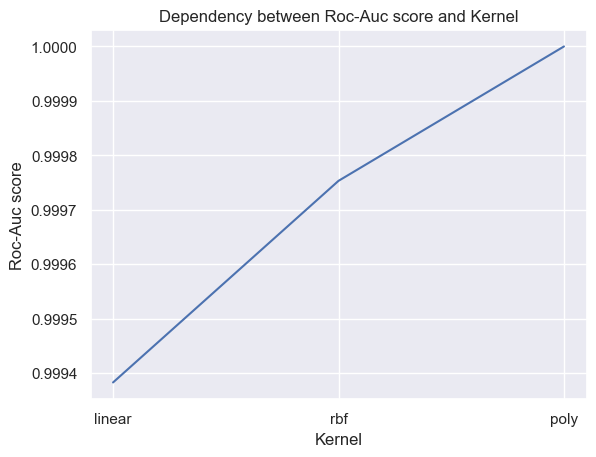

In [10]:
plt.plot(kernels, roc_auc_scores)
plt.xlabel('Kernel')
plt.ylabel('Roc-Auc score')
plt.title('Dependency between Roc-Auc score and Kernel')

In [11]:
C = 0.1
Cs = []
f1_scores = []
accuracies = []
roc_auc_scores = []
while C <= 1:
    Cs.append(C)
    model = svm.SVC(C=C, kernel='rbf', gamma='scale',tol=1e-2, probability=True)
    model.fit(X, y)
    y_pred = model.predict(X)
    proba  = model.predict_proba(X)
    f1_scores.append(f1_score(y, y_pred, average='weighted'))
    accuracies.append(accuracy_score(y, y_pred))
    roc_auc_scores.append(roc_auc_score(y, proba[:,1]))
    C = C + 0.1

Все метрики увеличиваются при увеличении коэффициента регуляризации,
следовательно, лучшим коэффициентом регуляризации является 1.
Наибольший рост всех 3-х метрик наблюдается при увеличении коэффициента
регуляризации от 0 до 0.3

Text(0.5, 1.0, 'Dependency between F1-score and Regularization coefficient')

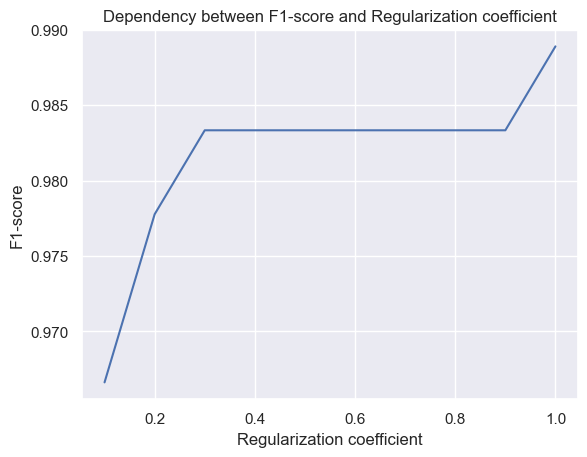

In [12]:
plt.plot(Cs, f1_scores)
plt.xlabel('Regularization coefficient')
plt.ylabel('F1-score')
plt.title('Dependency between F1-score and Regularization coefficient')

Text(0.5, 1.0, 'Dependency between Accuracy and Regularization coefficient')

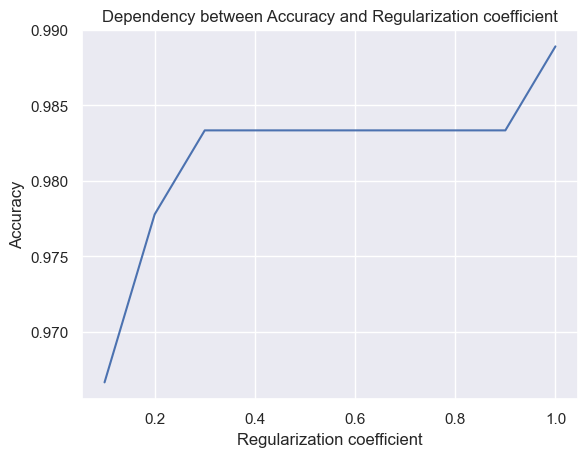

In [13]:
plt.plot(Cs, accuracies)
plt.xlabel('Regularization coefficient')
plt.ylabel('Accuracy')
plt.title('Dependency between Accuracy and Regularization coefficient')

Text(0.5, 1.0, 'Dependency between Roc-Auc score and Regularization coefficient')

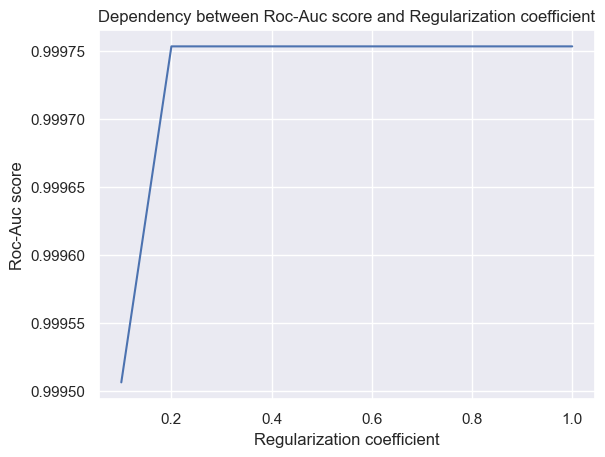

In [14]:
plt.plot(Cs, roc_auc_scores)
plt.xlabel('Regularization coefficient')
plt.ylabel('Roc-Auc score')
plt.title('Dependency between Roc-Auc score and Regularization coefficient')

Для ядра 'poly' метрики модели являются наилучшими при значении гиперпараметра
degree, равного 3. При этом по графику заметно, что увеличение степени degree
приводит к постепенному ухудшению метрик, несмотря на маленькие промежутки
возрастания функции зависимости метрик от degree.

In [15]:
deg = 1
degrees = []
f1_scores = []
accuracies = []
roc_auc_scores = []
while deg <= 10:
    degrees.append(deg)
    model = svm.SVC(C=0.6, kernel='poly', gamma='scale', degree=deg, tol=1e-2, probability=True)
    model.fit(X, y)
    y_pred = model.predict(X)
    proba  = model.predict_proba(X)
    f1_scores.append(f1_score(y, y_pred, average='weighted'))
    accuracies.append(accuracy_score(y, y_pred))
    roc_auc_scores.append(roc_auc_score(y, proba[:,1]))
    deg = deg + 1


Text(0.5, 1.0, 'Dependency between F1-score and Degree')

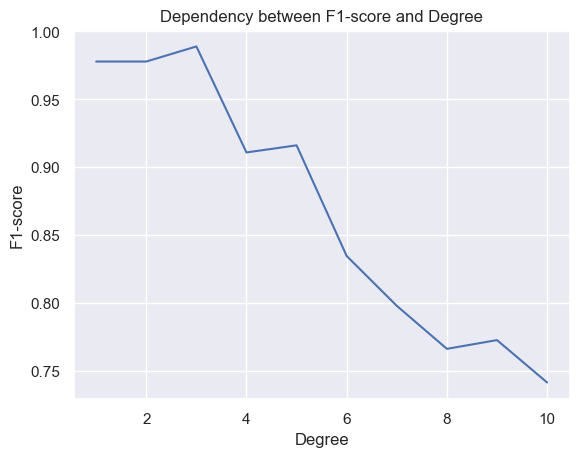

In [16]:
plt.plot(degrees, f1_scores)
plt.xlabel('Degree')
plt.ylabel('F1-score')
plt.title('Dependency between F1-score and Degree')

Text(0.5, 1.0, 'Dependency between Accuracy and Degree')

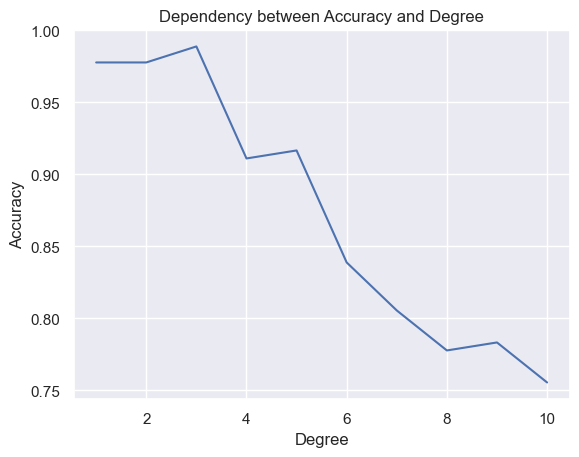

In [17]:
plt.plot(degrees, accuracies)
plt.xlabel('Degree')
plt.ylabel('Accuracy')
plt.title('Dependency between Accuracy and Degree')

Text(0.5, 1.0, 'Dependency between Roc-Auc score and Degree')

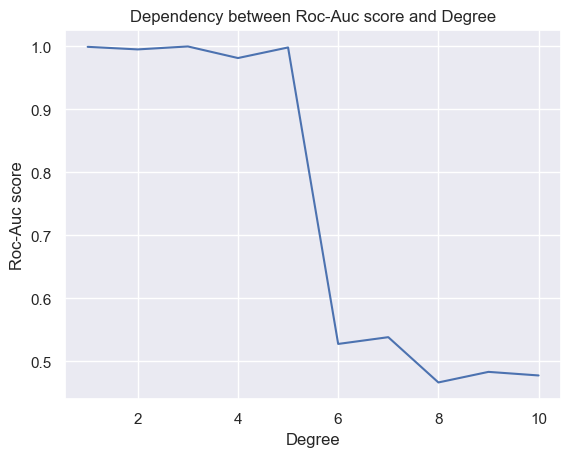

In [18]:
plt.plot(degrees, roc_auc_scores)
plt.xlabel('Degree')
plt.ylabel('Roc-Auc score')
plt.title('Dependency between Roc-Auc score and Degree')

In [19]:
coef = -100.0
coefs = []
f1_scores = []
accuracies = []
roc_auc_scores = []
while coef <= 100:
    coefs.append(coef)
    model = svm.SVC(C=0.6, kernel='poly', gamma='scale', coef0=coef, tol=1e-2, probability=True)
    model.fit(X, y)
    y_pred = model.predict(X)
    proba  = model.predict_proba(X)
    f1_scores.append(f1_score(y, y_pred, average='weighted'))
    accuracies.append(accuracy_score(y, y_pred))
    roc_auc_scores.append(roc_auc_score(y, proba[:,1]))
    coef = coef + 10

Из графиков видно, что для хороших показателей модели лучше
использовать положительные значения coef0

Text(0.5, 1.0, 'Dependence between F1-score and coef0')

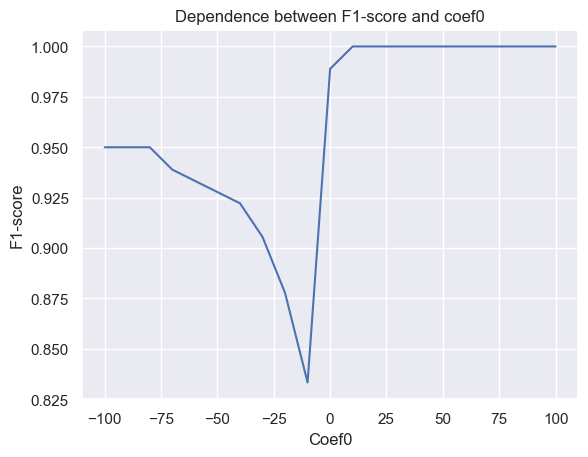

In [20]:
plt.plot(coefs, f1_scores)
plt.xlabel('Coef0')
plt.ylabel('F1-score')
plt.title('Dependence between F1-score and coef0')

Text(0.5, 1.0, 'Dependence between Accuracy and coef0')

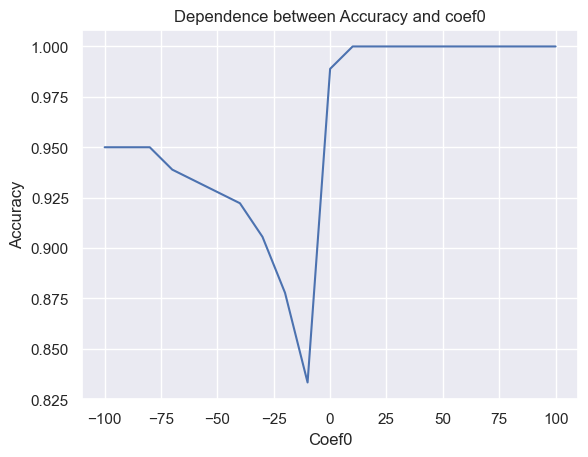

In [21]:
plt.plot(coefs, accuracies)
plt.xlabel('Coef0')
plt.ylabel('Accuracy')
plt.title('Dependence between Accuracy and coef0')

Text(0.5, 1.0, 'Dependence between Roc-Auc score and coef0')

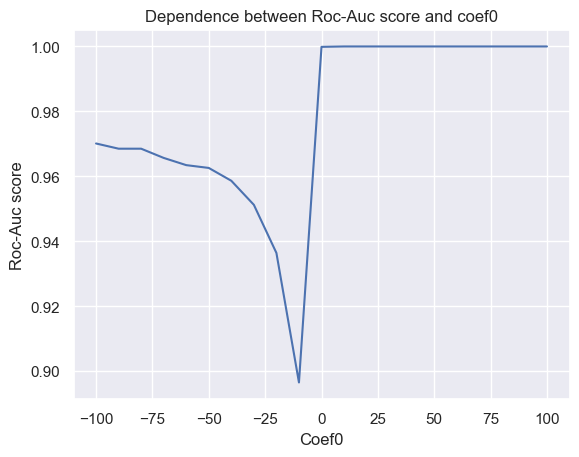

In [22]:
plt.plot(coefs, roc_auc_scores)
plt.xlabel('Coef0')
plt.ylabel('Roc-Auc score')
plt.title('Dependence between Roc-Auc score and coef0')

In [23]:
gammas = []
gamma = 0.1
f1_scores = []
accuracies = []
roc_auc_scores = []
while gamma <= 1:
    gammas.append(gamma)
    model = svm.SVC(kernel='rbf', gamma=gamma,tol=1e-2, probability=True)
    model.fit(X, y)
    y_pred = model.predict(X)
    proba  = model.predict_proba(X)
    f1_scores.append(f1_score(y, y_pred, average='weighted'))
    accuracies.append(accuracy_score(y, y_pred))
    roc_auc_scores.append(roc_auc_score(y, proba[:,1]))
    gamma += 0.1

Для ядра 'rbf' увеличение гиперпараметра gamma ведет к улучшению
метрик модели.
На графике зависимости между roc-auc score и gamma есть аномальный
выброс при gamma = 0.5 (резкое ухудшение метрики), но после этого
функция зависимости сразу начинает возрастать.

Text(0.5, 1.0, 'Dependence between F1-score and gamma')

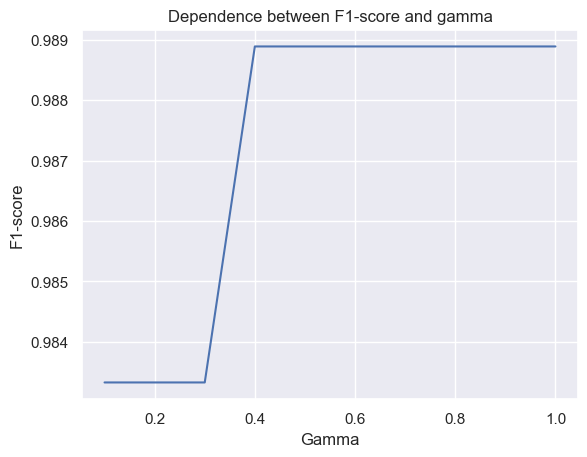

In [24]:
plt.plot(gammas, f1_scores)
plt.xlabel('Gamma')
plt.ylabel('F1-score')
plt.title('Dependence between F1-score and gamma')

Text(0.5, 1.0, 'Dependence between Accuracy and gamma')

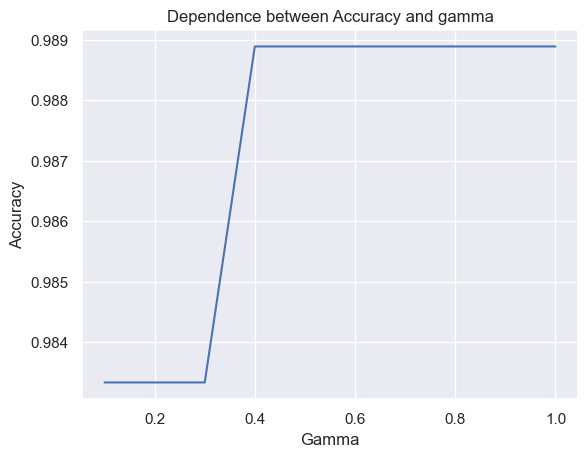

In [25]:
plt.plot(gammas, accuracies)
plt.xlabel('Gamma')
plt.ylabel('Accuracy')
plt.title('Dependence between Accuracy and gamma')

Text(0.5, 1.0, 'Dependence between Roc-Auc score and gamma')

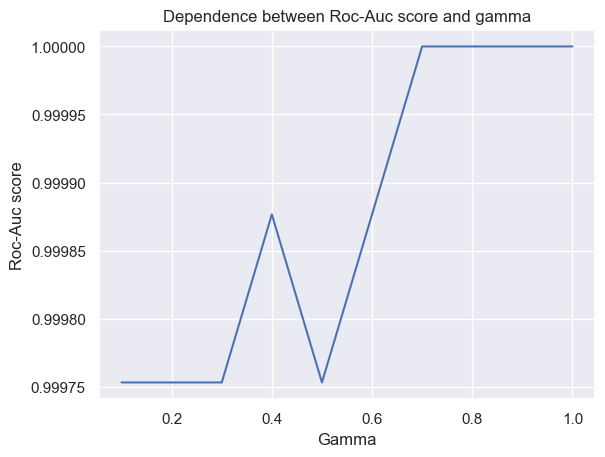

In [26]:
plt.plot(gammas, roc_auc_scores)
plt.xlabel('Gamma')
plt.ylabel('Roc-Auc score')
plt.title('Dependence between Roc-Auc score and gamma')

In [27]:
tols = []
tol = 1e-10
f1_scores = []
accuracies = []
roc_auc_scores = []
while tol <= 10:
    tols.append(tol)
    model = svm.SVC(kernel='poly', gamma='scale',tol=tol, probability=True)
    model.fit(X, y)
    y_pred = model.predict(X)
    proba  = model.predict_proba(X)
    f1_scores.append(f1_score(y, y_pred, average='weighted'))
    accuracies.append(accuracy_score(y, y_pred))
    roc_auc_scores.append(roc_auc_score(y, proba[:,1]))
    tol *= 10

Из графиков очевидно, что все метрики ухудшаются при увеличении
tolerance.

Text(0.5, 1.0, 'Dependence between F1-score and tolerance')

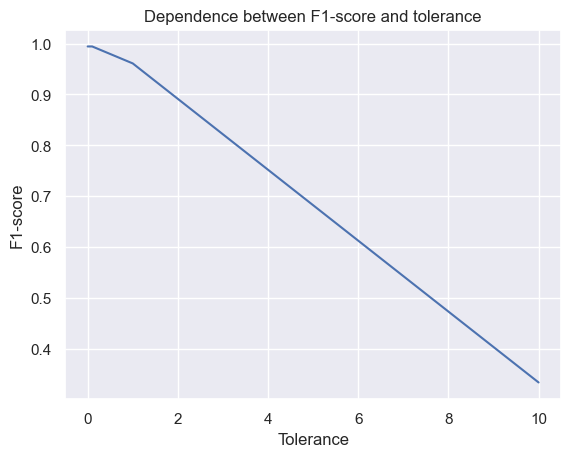

In [28]:
plt.plot(tols, f1_scores)
plt.xlabel('Tolerance')
plt.ylabel('F1-score')
plt.title('Dependence between F1-score and tolerance')

Text(0.5, 1.0, 'Dependence between Accuracy and tolerance')

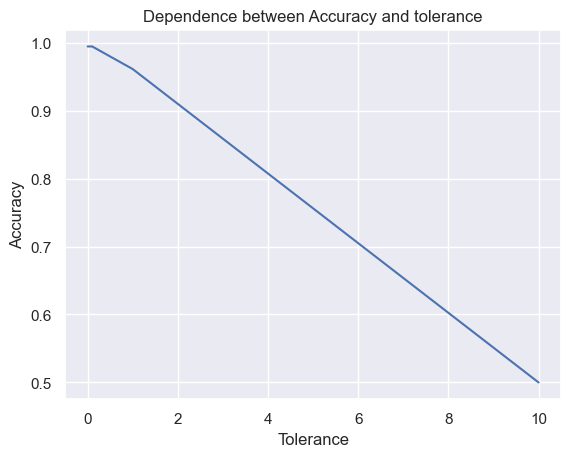

In [29]:
plt.plot(tols, accuracies)
plt.xlabel('Tolerance')
plt.ylabel('Accuracy')
plt.title('Dependence between Accuracy and tolerance')

Text(0.5, 1.0, 'Dependence between Roc-Auc score and tolerance')

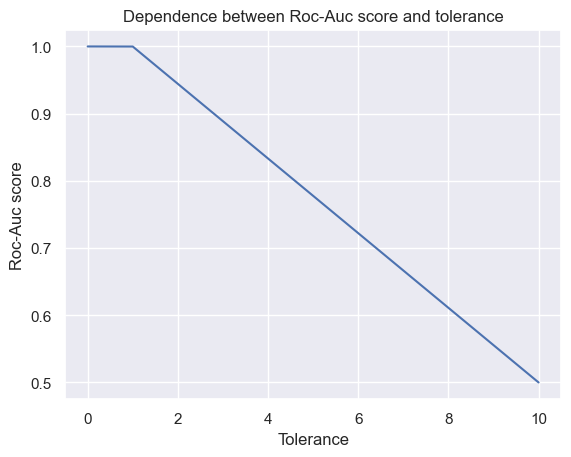

In [30]:
plt.plot(tols, roc_auc_scores)
plt.xlabel('Tolerance')
plt.ylabel('Roc-Auc score')
plt.title('Dependence between Roc-Auc score and tolerance')

Предполагаю, что более всего к переобучению склонно ядро 'poly', так как при маленьких
degree модель с ядром 'poly' демонстрирует очень хорошие (наилучшие) показатели, при этом
при увеличении степени полиномиального ядра ее показатели начинают ухудшаться, что говорит
о том, что с увеличением степени все больше и больше становится заметной переобученность
модели

## PART 3: Natural Language Processing

#### 7. [1.75 point] Form the dataset

We are going to form a dataset that we will use in the following tasks for binary and multiclass classification

0. Choose **six** authors that you like (specify who you've chosen) and download the <a href="https://www.kaggle.com/d0rj3228/russian-literature?select=prose">relevant data</a> from **prose** section
1. Build your own dataset for these authors: 
    * divide each text into sentences such that we will have two columns: *sentence* and *target author*, each row will contain one sentence and one target
    * drop sentences where N symbols in a sentence < 15
    * fix random state and randomly choose sentences in the folowing proportion "5k : 15k : 8k : 11k : 20k : 3k" for the authors respectively
    
    sample data may look like:
    
    <center> 
    <table>
        <tr>
            <th> sentence </th>
            <th> author </th>
        </tr> 
        <tr><td> Несколько лет тому назад в одном из своих поместий жил старинный русской барин, Кирила Петрович Троекуров. </td><td> Пушкин </td><td> 
        <tr><td> Уже более недели приезжий господин жил в городе, разъезжая по вечеринкам и обедам и таким образом проводя, как говорится, очень приятно время. </td><td> Гоголь </td><td> 
        <tr><td> ... </td><td> ... </td><td> 
        <tr><td> Я жил недорослем, гоняя голубей и играя в чехарду с дворовыми мальчишками. </td><td> Пушкин </td><td>         
    </table>
</center>
     
2. Preprocess (tokenize and clean) the dataset 
    * tokenize, remove all stop words (nltk.corpus.stopwords), punctuation (string.punctuation) and numbers
    * convert to lower case and apply either stemming or lemmatization of the words (on your choice)
    * vectorize words using both **bag of words** and **tf-idf** (use sklearn)
    * observe and describe the difference between vectorized output (what do numbers look like after transformations and what do they represent?)

Формирование литературного датасета

In [11]:
!pip install pymorphy2
import numpy as np
import pandas as pd
import random
import glob
import pickle
from collections import Counter
import re
import nltk

from pymorphy2 import MorphAnalyzer
from nltk.corpus import stopwords
from nltk import tokenize

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.ensemble import RandomForestClassifier

import matplotlib.pyplot as plt
import seaborn as sns

labelencoder=LabelEncoder()
nltk.download('punkt')

# function for splitting text into sentences.

def splitting_text(filepath):
    with open(filepath, 'r', encoding='utf8') as book:
        text_to_tokenize = book.read().replace('\n', '. ')
        sentences = tokenize.sent_tokenize(text_to_tokenize)
    sentences = [sentence for sentence in sentences if (len(sentence) >= 15)]
    return sentences

favorite_authors = ['Chekhov', 'Tolstoy', 'Pushkin', 'Lermontov', 'Turgenev', 'Gogol']
authors_books = {}

# opening files with author texts, splitting texts into sentences and adding split
# texts to dictionary for each author.

for author in favorite_authors:
    books_sentences = []
    for filepath in glob.glob('prose/{}/*.txt'.format(author)):
        books_sentences += splitting_text(filepath)
    authors_books[author] = books_sentences

sum_of_lengths = 0

# counting the total amount of sentences

for key in authors_books.keys():
    print(key, ':', len(authors_books[key]), ' sentences')
    sum_of_lengths += len(authors_books[key])

k = sum_of_lengths // 62

# weights of authors for making proportion
weights = {'Chekhov': 5, 'Tolstoy': 20, 'Pushkin': 3, 'Lermontov' : 11, 'Turgenev' : 15, 'Gogol' : 8}

final_text_and_author = []
text_and_author = []
for key, value in authors_books.items():
    for sentence in value:
        text_and_author.append((sentence, key))
    # the amount of sentences, which we should choose according to proportion.
    count = weights[key] * k
    # randomly choosing count sentences from all sentences of the author.
    text_and_author = \
        random.choices(text_and_author, k=count)
    final_text_and_author += text_and_author
    text_and_author.clear()

dataset = pd.DataFrame(final_text_and_author, columns=['sentence', 'author'])
np.random.shuffle(dataset.values)
dataset.head(30)


[notice] A new release of pip available: 22.3 -> 22.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\tanya\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Chekhov : 19088  sentences
Tolstoy : 71483  sentences
Pushkin : 8920  sentences
Lermontov : 4495  sentences
Turgenev : 20093  sentences
Gogol : 20519  sentences


,sentence,author
0,"Второй сын Дюди, горбатенький Алёшка, живет до...",Chekhov
1,"– сказала она робко, боясь ошибиться.. «Н...",Tolstoy
2,"проклятый народ, сразу не убьешь.. Четвер...",Lermontov
3,"Ведь три года его не видала, не кормила, не по...",Turgenev
4,"Чтобы скрыть это смущение, он достал только чт...",Tolstoy
5,"— «Хоть бы в Арзерум поспеть нонче», — отвечал...",Lermontov
6,Я не смел взглянуть Пасын-кову в глаза.),Turgenev
7,ущелье; за ним и впереди нас темно-синие верш...,Lermontov
8,— сказал Шешковский.. Все трое вылезли из коля...,Chekhov
9,Простите за самолюбие родства – я никогда в эт...,Tolstoy


Обработка данных из датасета

In [12]:
import string
import pymorphy2

morph = pymorphy2.MorphAnalyzer()
nltk.download('stopwords')
stop_words = nltk.corpus.stopwords.words('russian')
word_tokenizer = nltk.WordPunctTokenizer()

tokenized_sentences = []
punctuation = string.punctuation

# splitting each sentence into word tokens.
for index, item in dataset.iterrows():
    lower_sentence = item['sentence'].lower()
    tokens = word_tokenizer.tokenize(lower_sentence)
    tokens = [word for word in tokens if (word not in string.punctuation and word not in stop_words and not word.isdigit())]
    tokenized_sentences.append(tokens)

# lemmatization of each word in each sentence.
lemmatized_tokenized_sentences = []
for sentence_list in tokenized_sentences:
    normalized_sentence = [morph.parse(x)[0].normal_form for x in sentence_list]
    lemmatized_tokenized_sentences.append(normalized_sentence)
lemmatized_tokenized_sentences

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\tanya\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


[['второй', 'сын', 'дюдить', 'горбатенький', 'алёшка', 'жить', 'дом', 'отец'],
 ['–',
  'сказать',
  'робко',
  'бояться',
  'ошибиться',
  '..',
  '«',
  'точно',
  'вздрогнуть',
  'точно',
  'подойти',
  'робко',
  'улыбнуться',
  'это',
  '»,',
  'подумать',
  'наташа',
  '«',
  'точно',
  '…',
  'подумать',
  'недоставать',
  '»..',
  '–',
  'это',
  'хор',
  'водонос',
  'слышать'],
 ['проклятый',
  'народ',
  'сразу',
  'убить',
  '..',
  'четверть',
  'час',
  'спустя',
  'печорин',
  'вернуться',
  'охота',
  'бэла',
  'броситься'],
 ['год', 'видать', 'кормить', 'поить', 'легко', '?.'],
 ['скрыть',
  'это',
  'смущение',
  'достать',
  'купить',
  'новый',
  'способ',
  'открывание',
  'папиросница',
  'понюхать',
  'кожа',
  'достать',
  'папироска',
  '..',
  '–'],
 ['—', '«', 'арзерум', 'поспеть', 'нонкий', '»,', '—', 'отвечать', 'ашик'],
 ['сметь', 'взглянуть', 'пасын', 'кова', 'глаз', '.)'],
 ['ущелие',
  'впереди',
  'темно',
  'синий',
  'вершина',
  'гора',
  'изрыть',


In [13]:
# making strings out of each list of words.
string_sentences = []
for sentence_list in lemmatized_tokenized_sentences:
    string_sentence = ""
    for word in sentence_list:
        string_sentence += (word + ' ')
    string_sentences.append(string_sentence)

Векторизация bag of words

In [14]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(max_features = 50)
vectorizer.fit(string_sentences)
train_X = vectorizer.transform(string_sentences)
train_X.todense()[:20]

matrix([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
         0, 0, 0, 0, 0, 0, 2, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 1,

Векторизация Tf-Idf

In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction import DictVectorizer

vec = TfidfVectorizer(max_features=50)
vec.fit(string_sentences)
train_X = vec.transform(string_sentences)
train_X.todense()[:20]

matrix([[0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         1.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 

После векторизации bag of words мы получили матрицу с целыми числами
В данной матрице строки означают документы, а столбцы - это слова из словаря.
И каждое число в данной матрице показывает, сколько раз определенное слово
встречается в определенном документе.
А после векторизации Tf-Idf мы получили матрицу с вещественными числами.
В данной матрице столбцы и строки обозначают то же самое, что и в матрице
bag of words, однако каждое число там - это частота данного слова в данном
документе, умноженная на логарифм отношения общего числа документов к числу
документов, в которых встречается данное слово.


###  Binary classification

#### 8. [2 point] Train model using Logistic Regression (your own) and SVC (SVM can be taken from sklearn) 

* choose *two* authors from the dataset that you have formed in the previous task
* check the balance of the classes
* divide the data into train and test samples with 0.7 split rate (don't forget to fix the random state)
* using GridSearchCV - find the best parameters for the models (by F1 score) and use it in the next tasks
* make several plots to address the dependence between F1 score and parameters
* plot confusion matrix for train and test samples
* compute some relevant metrics for test sample (useful to check the seminars 5 and 6, use sklearn) 
* make conclusions about the performance of your models


In [17]:
# Extracting only Chekhov and Tolstoy sentences
chekhov_tolstoy_dataset = dataset[dataset['author'] == 'Chekhov']
chekhov_tolstoy_dataset = chekhov_tolstoy_dataset.append(dataset[dataset['author'] == 'Tolstoy'])
np.random.shuffle(chekhov_tolstoy_dataset.values)
chekhov_tolstoy_dataset.head(30)

C:\Users\tanya\AppData\Local\Temp\ipykernel_17128\230753608.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chekhov_tolstoy_dataset = chekhov_tolstoy_dataset.append(dataset[dataset['author'] == 'Tolstoy'])


,sentence,author
0,Варя (из другой комнаты).,Chekhov
8,замечая его угрюмого вида.. Корней глян...,Tolstoy
21,"— сказал Пьер.. — У графа был ячмень, — с...",Tolstoy
30,"Мы с ним невольно подружились, живя вместе, и ...",Tolstoy
32,"Если б не был хорошим, то разве его посвятили ...",Chekhov
48,– сказал из спальни повелительный голос доктор...,Tolstoy
62,Бедняжка сгорела от стыда.... — Митька дверей ...,Chekhov
91,Умная женщина была.. Только и мог узнать Не...,Tolstoy
101,А я хотел к вам посылать.,Tolstoy
131,"68 г.: чувствовал,.",Tolstoy


In [18]:
chekhov_count = chekhov_tolstoy_dataset["author"].value_counts()["Chekhov"]
tolstoy_count = chekhov_tolstoy_dataset["author"].value_counts()["Tolstoy"]
chekhov_tolstoy_dataset.groupby('author').count()

,sentence
author,
Chekhov,11660
Tolstoy,46640


In [19]:
if chekhov_count != tolstoy_count:
    print('Classes are not balanced')
else:
    print('Classes are balanced')

Classes are not balanced


Предобработка данных о Чехове и Толстом

In [20]:
morph = pymorphy2.MorphAnalyzer()
stop_words = nltk.corpus.stopwords.words('russian')
word_tokenizer = nltk.WordPunctTokenizer()
tokenized_chekhov_tolstoy_sentences = []
punctuation = string.punctuation
for index, item in chekhov_tolstoy_dataset.iterrows():
    lower_sentence_chekhov_tolstoy = item['sentence'].lower()
    tokens_chekhov_tolstoy = word_tokenizer.tokenize(lower_sentence_chekhov_tolstoy)
    tokens_chekhov_tolstoy = [word for word in tokens_chekhov_tolstoy if (word not in string.punctuation and word not in stop_words and not word.isdigit())]
    tokenized_chekhov_tolstoy_sentences.append(tokens_chekhov_tolstoy)

lemmatized_tokenized_sentences_chekhov_tolstoy = []
for sentence_list in tokenized_chekhov_tolstoy_sentences:
    normalized_sentence = [morph.parse(x)[0].normal_form for x in sentence_list]
    lemmatized_tokenized_sentences_chekhov_tolstoy.append(normalized_sentence)

Разделение данных на тренировочную и тестовую части

In [21]:
from sklearn.model_selection import train_test_split
train_texts, test_texts, train_y, test_y = train_test_split(lemmatized_tokenized_sentences_chekhov_tolstoy, [1 if x == 'Tolstoy'  else -1 for x in chekhov_tolstoy_dataset['author']], test_size=0.3, random_state=42, stratify = chekhov_tolstoy_dataset['author'])

Векторизация bag of words

In [22]:
train_sentences = []
test_sentences = []
for sentence_list in train_texts:
    string_sentence = ""
    for word in sentence_list:
        string_sentence += (word + ' ')
    train_sentences.append(string_sentence)
for sentence_list in test_texts:
    string_sentence = ""
    for word in sentence_list:
        string_sentence += (word + ' ')
    test_sentences.append(string_sentence)

vectorizer = CountVectorizer(max_features = 50)
vectorizer.fit(train_sentences)
train_X = vectorizer.transform(train_sentences)
test_X  = vectorizer.transform(test_sentences)
train_X = np.asarray(train_X.todense())
train_y = np.array(train_y).T
test_y = np.array(test_y).T
test_X = np.asarray(test_X.todense())

GridSearch для параметров SVC

In [ ]:
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
logit = SVC()
parameters = {'kernel':('linear', 'rbf', 'poly', 'sigmoid'), 'C':[0.001, 0.01, 0.1, 1, 10, 100],\
              'decision_function_shape' : ['ovo', 'ovr']}
my_scorer = make_scorer(f1_score, greater_is_better=True, average='micro')
svr = SVC(verbose = False, probability=True)
model = GridSearchCV(svr, parameters, scoring=my_scorer, cv=2, verbose=2)
model.fit(train_X, train_y)
print(model.best_params_)

[CV] END ....C=0.01, decision_function_shape=ovo, kernel=rbf; total time= 2.9min
[CV] END ....C=0.01, decision_function_shape=ovo, kernel=rbf; total time= 3.2min
[CV] END ...C=0.01, decision_function_shape=ovo, kernel=poly; total time= 2.7min
[CV] END ...C=0.01, decision_function_shape=ovo, kernel=poly; total time= 2.5min
[CV] END C=0.01, decision_function_shape=ovo, kernel=sigmoid; total time= 2.1min
[CV] END C=0.01, decision_function_shape=ovo, kernel=sigmoid; total time= 2.0min
[CV] END .C=0.01, decision_function_shape=ovr, kernel=linear; total time= 1.6min
[CV] END .C=0.01, decision_function_shape=ovr, kernel=linear; total time= 1.6min
[CV] END ....C=0.01, decision_function_shape=ovr, kernel=rbf; total time= 2.8min
[CV] END ....C=0.01, decision_function_shape=ovr, kernel=rbf; total time= 2.8min
[CV] END ...C=0.01, decision_function_shape=ovr, kernel=poly; total time= 2.4min
[CV] END ...C=0.01, decision_function_shape=ovr, kernel=poly; total time= 2.4min
[CV] END C=0.01, decision_fu

In [ ]:
svm_results = model.cv_results_
parameters_table = pd.DataFrame(svm_results)
parameters_table = parameters_table[parameters_table['param_decision_function_boundary'] == 'ovo']
f1_scores_linear_kernel = parameters_table[parameters_table['param_kernel'] == 'linear']['mean_test_score']
f1_scores_poly_kernel = parameters_table[parameters_table['param_kernel'] == 'poly']['mean_test_score']
f1_scores_rbf_kernel = parameters_table[parameters_table['param_kernel'] == 'rbf']['mean_test_score']
f1_scores_sigmoid_kernel = parameters_table[parameters_table['param_kernel'] == 'sigmoid']['mean_test_score']

plt.plot(parameters['С'], f1_scores_linear_kernel)
plt.plot(parameters['С'], f1_scores_rbf_kernel)
plt.plot(parameters['С'], f1_scores_poly_kernel)
plt.plot(parameters['С'], f1_scores_sigmoid_kernel)
plt.legend(['linear', 'rbf', 'poly', 'sigmoid'])
plt.xlabel('Regularization coefficient')
plt.ylabel('F1-score')
plt.title('Dependence of f1-score on regularization coefficient for different kernels')

GridSearch для параметров Logit-модели

In [23]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
log = Logit(0,0)
parameters = {'tolerance':[0.1, 0.01, 0.001, 0.0001, 0.00001], 'max_iter':[10, 100, 1000, 10000, 20000]}
my_scorer = make_scorer(f1_score, greater_is_better=True, average='micro')
model = GridSearchCV(log, parameters, scoring=my_scorer, cv=2, verbose=2)
model.fit(train_X, train_y)
print(model.best_params_)

Fitting 2 folds for each of 25 candidates, totalling 50 fits
[CV] END .........................max_iter=10, tolerance=0.1; total time=   0.0s
[CV] END .........................max_iter=10, tolerance=0.1; total time=   0.0s
[CV] END ........................max_iter=10, tolerance=0.01; total time=   0.0s
[CV] END ........................max_iter=10, tolerance=0.01; total time=   0.0s
[CV] END .......................max_iter=10, tolerance=0.001; total time=   0.0s
[CV] END .......................max_iter=10, tolerance=0.001; total time=   0.0s
[CV] END ......................max_iter=10, tolerance=0.0001; total time=   0.2s
[CV] END ......................max_iter=10, tolerance=0.0001; total time=   0.3s
[CV] END .......................max_iter=10, tolerance=1e-05; total time=   0.5s
[CV] END .......................max_iter=10, tolerance=1e-05; total time=   0.5s
[CV] END ........................max_iter=100, tolerance=0.1; total time=   0.0s
[CV] END ........................max_iter=100, t

Графики зависимости F1-score от параметров модели Logit

Text(0, 0.5, 'f1-score')

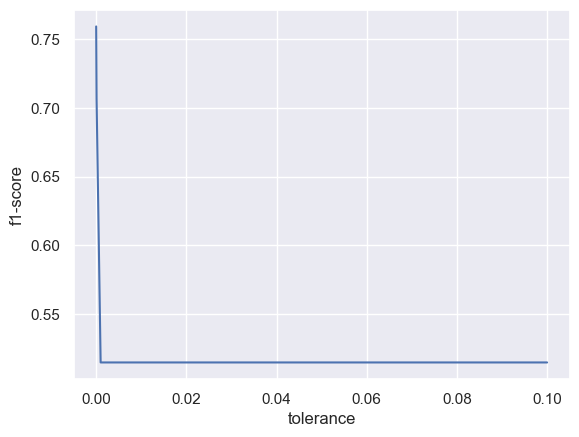

In [33]:
logit_results = model.cv_results_
logit_parameters_table = pd.DataFrame(logit_results)
f1_scores = logit_parameters_table[logit_parameters_table['param_max_iter'] == 20000]['mean_test_score']
plt.plot(parameters['tolerance'], f1_scores)

plt.xlabel('tolerance')
plt.ylabel('f1-score')
plt.title('Dependence of f1-score on tolerance for max_iter = 20000')

Обучение модели SVC с лучшими параметрами

In [34]:
from sklearn.metrics import confusion_matrix

model = svm.SVC(C=1, kernel='rbf', gamma='scale', decision_function_shape='ovo', probability=True)
model.fit(train_X, train_y)

SVC(C=1, decision_function_shape='ovo', probability=True)

In [36]:
test_y_pred = model.predict(test_X)
test_proba  = model.predict_proba(test_X)
train_y_pred = model.predict(train_X)
train_proba  = model.predict_proba(train_X)
print("F1-measure: {0:6.2f}".format(f1_score(test_y, test_y_pred, average='weighted')))
print("Accuracy: {0:6.2f}".format(accuracy_score(test_y, test_y_pred)))
print("ROC-AUC  =  {0:6.2f}".format(roc_auc_score(test_y, test_proba[:,1]),))

F1-measure:   0.72
Accuracy:   0.80
ROC-AUC  =    0.60


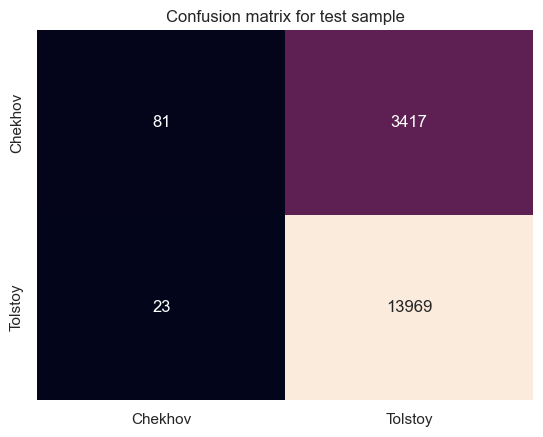

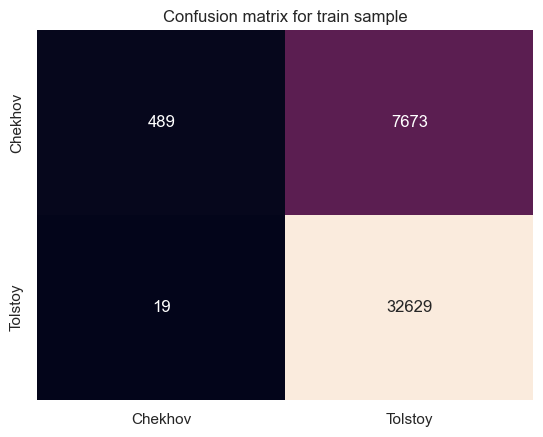

In [37]:
sns.heatmap(data=confusion_matrix(test_y, test_y_pred), annot=True, fmt="d", cbar=False, xticklabels=['Chekhov', 'Tolstoy'], yticklabels=['Chekhov', 'Tolstoy'])
plt.title("Confusion matrix for test sample")
plt.show()
sns.heatmap(data=confusion_matrix(train_y, train_y_pred), annot=True, fmt="d", cbar=False, xticklabels=['Chekhov', 'Tolstoy'], yticklabels=['Chekhov', 'Tolstoy'])
plt.title("Confusion matrix for train sample")
plt.show()

Обучение модели Logit с лучшими параметрами

In [38]:
model = Logit(0,0, lr=0.01, tolerance=0.00001, max_iter=20000)
model.fit(train_X, train_y)

Logit(beta=0, gamma=0, lr=0.01, max_iter=20000, tolerance=1e-05)

In [39]:
y_logit_pred = model.predict(test_X)
logit_proba  = model.predict_proba(test_X).T
print("F1-measure: {0:6.2f}".format(f1_score(test_y, y_logit_pred, average='weighted')))
print("Accuracy: {0:6.2f}".format(accuracy_score(test_y, y_logit_pred)))
print("ROC-AUC  =  {0:6.2f}".format(roc_auc_score(test_y, logit_proba[:,1]),))

F1-measure:   0.71
Accuracy:   0.80
ROC-AUC  =    0.59


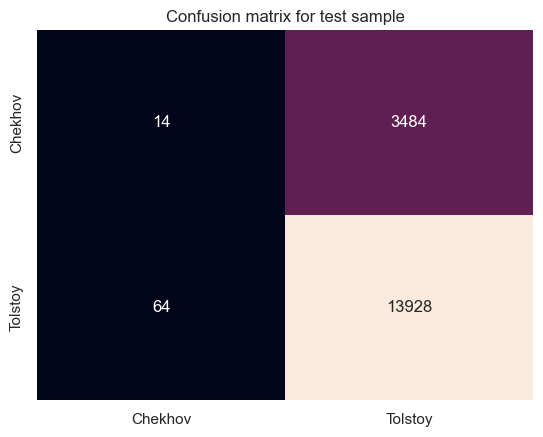

In [40]:
sns.heatmap(data=confusion_matrix(test_y, y_logit_pred), annot=True, fmt="d", cbar=False, xticklabels=['Chekhov', 'Tolstoy'], yticklabels=['Chekhov', 'Tolstoy'])
plt.title("Confusion matrix for test sample")
plt.show()

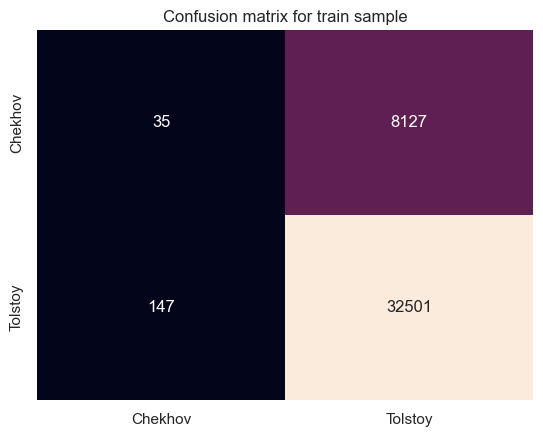

In [41]:
y_logit_train_pred = model.predict(train_X)
train_logit_proba  = model.predict_proba(test_X).T
sns.heatmap(data=confusion_matrix(train_y, y_logit_train_pred), annot=True, fmt="d", cbar=False, xticklabels=['Chekhov', 'Tolstoy'], yticklabels=['Chekhov', 'Tolstoy'])
plt.title("Confusion matrix for train sample")
plt.show()

Модели работают лучше, чем модель, предсказывающая рандомные значения, однако
точность моделей нельзя назвать высокой

#### 9. [1 point] Analysing ROC AUC

It is possible to control the proportion of statistical errors of different types using different thresholds for choosing a class. Plot ROC curves for Logistic Regression and SVC, show the threshold on ROC curve plots. Choose such a threshold that your models have no more than 30% of false positive errors rate. Pay attention to `thresholds` parameter in sklearn roc_curve 

In [58]:
from sklearn.metrics import roc_curve
import sklearn

fpr, tpr, thresholds = roc_curve(test_y, test_proba[:, 1])
# Searching for the minimum threshold, when the fpr is no more than 0.3
index_svc = 0
counter = 0
for i  in fpr:
    if i > 0.3:
        index_svc = counter - 1
        break
    else:
        if i == 0.3:
            index_svc = counter
            break
    counter += 1
print('Threshold' , thresholds[index_svc])

Threshold 0.8120960198589302


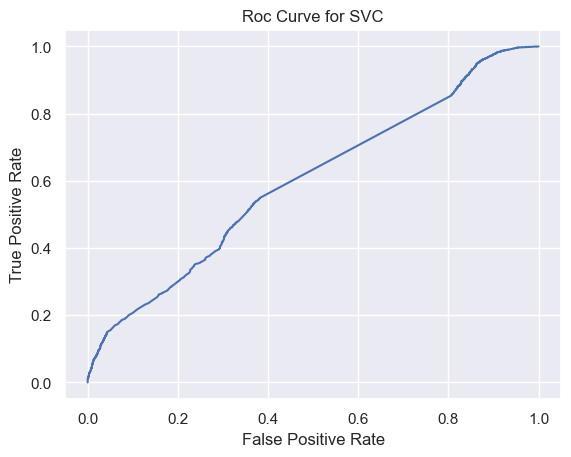

In [59]:
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('Roc Curve for SVC')
plt.show()

In [60]:
fpr, tpr, thresholds_logit = roc_curve(test_y, logit_proba[:, 1])
index_logit = 0
counter = 0
for i  in fpr:
    if i > 0.3:
        index_logit = counter - 1
        break
    else:
        if i == 0.3:
            index_logit = counter
            break
    counter += 1
print('Threshold - ', thresholds_logit[index_logit])

Threshold -  0.8005845169214129


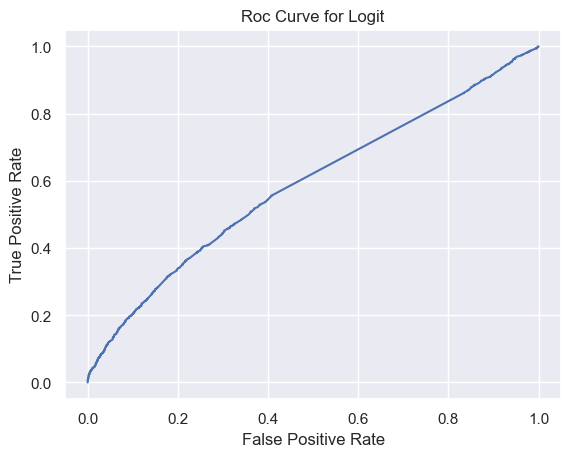

In [61]:
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('Roc Curve for Logit')
plt.show()

### Multiclass logit

#### 10. [1 point] Take the One-VS-One classifier (use sklearn) and apply to Logit model (one you've made in the 4th task) in order to get multiclass linear classifier

<a href="https://scikit-learn.org/stable/modules/generated/sklearn.multiclass.OneVsOneClassifier.html">OneVsOneClassifier</a>

* use the data you got at the previous step for 6 authors
* divide the data into train and test samples with 0.7 split rate
* using GridSearchCV - find the best parameters for the models (by F1 score)
* plot confusion matrix for train and test samples
* compute all possible and relevant metrics for test sample (use sklearn)

In [ ]:
from sklearn.metrics import make_scorer
from sklearn.multiclass import OneVsOneClassifier
from sklearn.model_selection import train_test_split
train_texts, test_texts, train_y, test_y = train_test_split(lemmatized_tokenized_sentences,
                    [1 if x == 'Pushkin' else
                     2 if x == 'Chekhov' else
                     3 if x == 'Tolstoy' else
                     4 if x == 'Turgenev' else
                     5 if x == 'Lermontov' else
                     6 for x in dataset['author']], test_size=0.3, random_state=42, stratify = dataset['author'])

train_sentences = []
test_sentences = []
for sentence_list in train_texts:
    string_sentence = ""
    for word in sentence_list:
        string_sentence += (word + ' ')
    train_sentences.append(string_sentence)
for sentence_list in test_texts:
    string_sentence = ""
    for word in sentence_list:
        string_sentence += (word + ' ')
    test_sentences.append(string_sentence)

vectorizer = TfidfVectorizer(max_features = 100)
vectorizer.fit(train_sentences)
train_X = vectorizer.transform(train_sentences)
test_X  = vectorizer.transform(test_sentences)
train_X = np.asarray(train_X.todense())
test_X = np.asarray(test_X.todense())
train_y = np.array(train_y).T
test_y = np.array(test_y).T

In [ ]:
from sklearn.metrics import multilabel_confusion_matrix, precision_score, recall_score
parameters = {'estimator__beta': [0.001, 0.01, 0.1, 1, 10, 100],'estimator__gamma': [0.001, 0.01, 0.1, 1, 10, 100],
              'estimator__tolerance' : [0.00001, 0.0001, 0.001, 0.01, 0.1], 'estimator__max_iter': [1000, 10000, 20000, 30000, 40000, 50000, 60000, 70000]}
my_scorer = make_scorer(f1_score, greater_is_better=True, average='micro')

svr = OneVsOneClassifier(Logit(0, 0, lr=0.01, tolerance=0.00001, max_iter=20000))
clf = GridSearchCV(svr, parameters, scoring=my_scorer, cv=2, verbose=2)
clf.fit(train_X, train_y)
train_predict = clf.predict(train_X)
test_predict = clf.predict(test_X)
proba = clf.predict_proba(test_X)

sns.heatmap(data=multilabel_confusion_matrix(train_y, train_predict,
            labels=['Tolstoy', 'Chekhov', 'Pushkin', 'Lermontov', 'Turgenev', 'Gogol']),
            annot=True, fmt="d", cbar=False, xticklabels=['Tolstoy', 'Chekhov', 'Pushkin', 'Lermontov', 'Turgenev', 'Gogol'],
            yticklabels=['Tolstoy', 'Chekhov', 'Pushkin', 'Lermontov', 'Turgenev', 'Gogol'])

sns.heatmap(data=multilabel_confusion_matrix(test_y, test_predict,
            labels=['Tolstoy', 'Chekhov', 'Pushkin', 'Lermontov', 'Turgenev', 'Gogol']),
            annot=True, fmt="d", cbar=False, xticklabels=['Tolstoy', 'Chekhov', 'Pushkin', 'Lermontov', 'Turgenev', 'Gogol'],
            yticklabels=['Tolstoy', 'Chekhov', 'Pushkin', 'Lermontov', 'Turgenev', 'Gogol'])


print('\n\n\nOneVsOne Strategy')
print('Best parameters: ', clf.best_params_)
print("F1 score  = {0:6.2f}".format(svr.score(test_X, test_y)))
print("Accuracy: {0:6.2f}".format(accuracy_score(test_y, test_predict)))
print("ROC-AUC  =  {0:6.2f}".format(roc_auc_score(test_y, proba[:,1]),))
print("Precision: {0:6.2f}".format(precision_score(test_y, test_predict)))
print("Precision: {0:6.2f}".format(recall_score(test_y, test_predict)))